In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
columns = ['JokeCount'] + [f'Joke{num + 1}' for num in range(100)]
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None, names=columns, na_values=99.00)
df = df.drop(columns=['JokeCount'])
values = df.values

In [4]:
df

,Joke1,Joke2,Joke3,Joke4,Joke5,Joke6,Joke7,Joke8,Joke9,Joke10,Joke11,Joke12,Joke13,Joke14,Joke15,Joke16,Joke17,Joke18,Joke19,Joke20,Joke21,Joke22,Joke23,Joke24,Joke25,Joke26,Joke27,Joke28,Joke29,Joke30,Joke31,Joke32,Joke33,Joke34,Joke35,Joke36,Joke37,Joke38,Joke39,Joke40,...,Joke61,Joke62,Joke63,Joke64,Joke65,Joke66,Joke67,Joke68,Joke69,Joke70,Joke71,Joke72,Joke73,Joke74,Joke75,Joke76,Joke77,Joke78,Joke79,Joke80,Joke81,Joke82,Joke83,Joke84,Joke85,Joke86,Joke87,Joke88,Joke89,Joke90,Joke91,Joke92,Joke93,Joke94,Joke95,Joke96,Joke97,Joke98,Joke99,Joke100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46,5.63,-0.92,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,7.43,5.39,2.23,-0.68,3.40,-0.58,4.42,...,8.59,3.45,0.87,9.27,-4.66,5.73,-0.49,8.35,1.94,5.00,-9.66,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,9.03,8.98,9.22,8.93,9.13,9.27,-1.99,-9.95,-9.90,9.13,8.83,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,8.88,-8.69,-7.48,-8.83,-1.75,6.60,3.54,1.50,7.67,-0.44,9.22,8.74,9.03,9.08,8.93,3.74,3.20,-9.17,-8.98,8.79,-7.67,-3.06,9.13,8.40,-0.63,-7.18,0.58,8.88,9.27,8.50,...,2.77,8.11,-7.96,8.93,-0.87,-5.87,8.88,-1.12,-8.74,8.74,NaN,NaN,NaN,NaN,NaN,4.90,NaN,NaN,NaN,NaN,-0.29,0.92,-0.78,0.15,-0.10,0.00,-0.19,-0.87,-1.36,-0.58,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,NaN,NaN,-6.46,-1.65,-6.80,-6.41,-6.99,7.23,6.75,-6.99,6.55,NaN,NaN,NaN,NaN,0.49,-0.53,-6.94,-0.49,NaN,6.46,-0.53,NaN,NaN,-7.86,-0.34,NaN,-6.94,NaN,NaN,...,0.49,-0.24,NaN,NaN,-3.11,-6.65,NaN,-0.58,

In [36]:
mean = df.mean(axis=0)
mean.sort_values()

Joke58   -3.833880
Joke16   -3.104818
Joke44   -2.111891
Joke57   -1.990664
Joke13   -1.762882
            ...   
Joke32    3.155988
Joke27    3.189821
Joke36    3.312500
Joke89    3.574720
Joke50    3.665085
Length: 100, dtype: float64

In [45]:
df.loc[5621, 'Joke9']

nan

In [18]:
df.iloc[2700]['Joke69']

4.71

In [19]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(values!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [22]:
new_values, validation_indices = replace(values, 0.1)

In [23]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10000) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [14]:
n_latent_factors = 4

user_ratings = df.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

Iteration 0/5:	MSE=22.117725


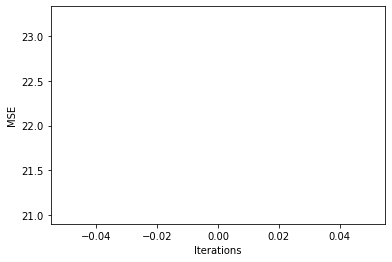

In [30]:
hist = sgd(5) 
plt.figure()
plt.plot(np.arange(0, 100, 10000), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [31]:
values_copy = values
validation_size = len(validation_indices[0])
errors = []
for i in range(validation_size):
  user_id = validation_indices[0][i]
  item_id = validation_indices[1][i]
  prediction_rating = predict_rating(user_id, item_id)
  rating = user_ratings[user_id, item_id]
  if not np.isnan(rating):
    real_rating = values_copy[user_id][item_id]
  error = prediction_rating - real_rating
  errors.append(error)
mse = (np.array(errors) ** 2).mean()
print('Validation MSE:', mse)

Validation MSE: nan


In [32]:
test = np.zeros(values_copy.shape)
r, c = values_copy.shape
for user_id in range(r):
  for item_id in range(c):
    if np.isnan(values_copy[user_id][item_id]):
      test[user_id][item_id] = predict_rating(user_id, item_id)
    else:
      test[user_id][item_id] = values_copy[user_id][item_id]

In [59]:
movie_items = pd.read_excel('https://github.com/albanda/CE888/blob/master/lab4-recommender/movies_latent_factors.xlsx?raw=true', sheet_name='Items')
movie_users = pd.read_excel('https://github.com/albanda/CE888/blob/master/lab4-recommender/movies_latent_factors.xlsx?raw=true', sheet_name='Users')

In [48]:
movie_items

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9806,The Incredibles (2004),0.159967,-0.051123,0.311183,1.841867,-1.952736,-0.836041,0.639252,-0.413082,-0.310868,0.448225,-0.846044,-0.158192,-0.649164,0.045580,1.017861
96,10020,Beauty and the Beast (1991),1.286288,0.004957,-0.157640,2.579640,-0.042687,-0.256582,-0.007971,0.458163,0.091394,0.323339,-0.862833,-0.508185,0.994535,0.868700,-0.487076
97,36657,X-Men (2000),0.811901,-0.893280,0.668953,-0.885074,-1.070468,-0.973154,-0.037449,-0.925609,-0.122112,-0.328822,-0.163103,-0.307299,0.642105,-1.355542,0.067790
98,36658,X2: X-Men United (2003),1.161006,-0.715613,0.712633,-0.688808,-0.717785,-1.007047,-0.267268,-0.802322,-0.249239,-0.540419,-0.291422,-0.240216,0.290714,-1.217250,-0.288130


In [ ]:
movie_items = movie_items.set_index('Movie ID')

In [64]:
movie_items.loc[77, 'Factor4']

-0.23793678204242188

In [65]:
movie_items.loc[:, 'Factor8'].sort_values()

Movie ID
272    -1.686344
155    -1.679131
8467   -1.283701
77     -1.122585
141    -0.987379
          ...   
114     1.283947
13      1.302036
597     1.747792
393     4.185528
24      4.630243
Name: Factor8, Length: 100, dtype: float64

In [49]:
movie_users

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669
5,783,-0.020301,-0.031919,-0.036955,0.033690,0.000174,-0.003178,0.054474,0.045424,-0.053308,0.003437,-0.041750,0.059725,-0.021647,0.039873,-0.061857
6,3878,-0.091462,0.215879,-0.180453,0.085408,-0.321094,0.227947,0.053767,0.038017,0.097141,-0.139872,0.029253,0.214467,0.189250,0.065990,0.102776
7,768,0.000819,-0.009229,-0.019228,0.002703,0.012869,0.006655,0.007687,0.018747,0.014705,-0.009256,-0.010116,-0.010051,-0.002108,0.043223,-0.006670
8,4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.019950,-0.014435,0.010926,0.024400,0.005318,-0.007983
9,1882,-0.083093,-0.029160,0.013748,0.022716,-0.062732,-0.080670,-0.019723,0.013253,-0.091305,-0.090687,0.030638,-0.113364,-0.021325,0.181508,0.022357
